# Desafio 1: Análise do Momento de Vida da Empresa

**Objetivo:** Identificar o momento de vida de uma empresa com base em seu comportamento financeiro transacional.

**Etapas:**
1. Carregamento e Preparação dos Dados
2. Engenharia de Features
3. Modelagem (Clusterização)
4. Análise e Visualização dos Resultados
5. Conclusão
6. Comparação de Modelos Supervisionados
7. Exportação de Dados para Power BI

## 1. Carregamento e Preparação dos Dados

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

df_id = pd.read_excel('data/Base1_ID.xlsx')
df_transacoes = pd.read_excel('data/Base2_Transacoes.xlsx')

df_id.rename(columns={'ID': 'id_empresa', 'VL_FATU': 'faturamento', 'DS_CNAE': 'setor_cnae', 'DT_REFE': 'data_referencia'}, inplace=True)
df_transacoes.rename(columns={'ID_PGTO': 'id_pagador', 'ID_RCBE': 'id_recebedor', 'VL': 'valor_transacao', 'DS_TRAN': 'tipo_transacao', 'DT_REFE': 'data_transacao'}, inplace=True)
df_id['data_referencia'] = pd.to_datetime(df_id['data_referencia'])
df_transacoes['data_transacao'] = pd.to_datetime(df_transacoes['data_transacao'])

## 2. Engenharia de Features

In [2]:
ids_unicos = pd.unique(np.concatenate((df_id['id_empresa'], df_transacoes['id_pagador'], df_transacoes['id_recebedor'])))
df_empresas = pd.DataFrame(ids_unicos, columns=['id_empresa']).set_index('id_empresa')

recebimentos = df_transacoes.groupby('id_recebedor').agg(total_recebido=('valor_transacao', 'sum'), num_transacoes_recebidas=('valor_transacao', 'count'), num_clientes_unicos=('id_pagador', 'nunique'))
pagamentos = df_transacoes.groupby('id_pagador').agg(total_pago=('valor_transacao', 'sum'), num_transacoes_pagas=('valor_transacao', 'count'), num_fornecedores_unicos=('id_recebedor', 'nunique'))

df_empresas = df_empresas.merge(recebimentos, left_index=True, right_index=True, how='left')
df_empresas = df_empresas.merge(pagamentos, left_index=True, right_index=True, how='left')
df_empresas.fillna(0, inplace=True)

df_empresas['fluxo_caixa_liquido'] = df_empresas['total_recebido'] - df_empresas['total_pago']
df_empresas['ticket_medio_recebido'] = df_empresas['total_recebido'] / df_empresas['num_transacoes_recebidas']
df_empresas['ticket_medio_pago'] = df_empresas['total_pago'] / df_empresas['num_transacoes_pagas']
df_empresas.fillna(0, inplace=True)

df_id_info = df_id.set_index('id_empresa')[['faturamento', 'setor_cnae']].drop_duplicates()
df_empresas = df_empresas.merge(df_id_info, left_index=True, right_index=True, how='left')

## 3. Modelagem (Clusterização)

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features_numericas = df_empresas.select_dtypes(include=np.number).columns.tolist()
df_modelo = df_empresas[features_numericas].copy()
df_modelo.fillna(df_modelo.median(), inplace=True)

scaler = StandardScaler()
dados_escalados = scaler.fit_transform(df_modelo)

k_otimo = 4
kmeans = KMeans(n_clusters=k_otimo, init='k-means++', n_init=10, random_state=42)
df_empresas['cluster'] = kmeans.fit_predict(dados_escalados)

## 4. Análise e Visualização dos Resultados

--- Perfil Médio de Cada Cluster ---
         total_recebido  num_transacoes_recebidas  num_clientes_unicos  \
cluster                                                                  
0          6.483966e+04                  3.980524             1.922893   
1          1.119910e+07                137.844380            60.634006   
2          7.432461e+06                 89.245283            39.641509   
3          7.843629e+04                  4.242297             2.032213   

           total_pago  num_transacoes_pagas  num_fornecedores_unicos  \
cluster                                                                
0        1.342054e+05              4.691116                 2.404100   
1        4.095766e+06             40.046110                26.841499   
2        1.888072e+07            262.547170                85.849057   
3        1.282280e+05              4.441176                 2.247899   

         fluxo_caixa_liquido  ticket_medio_recebido  ticket_medio_pago  \
cluster    

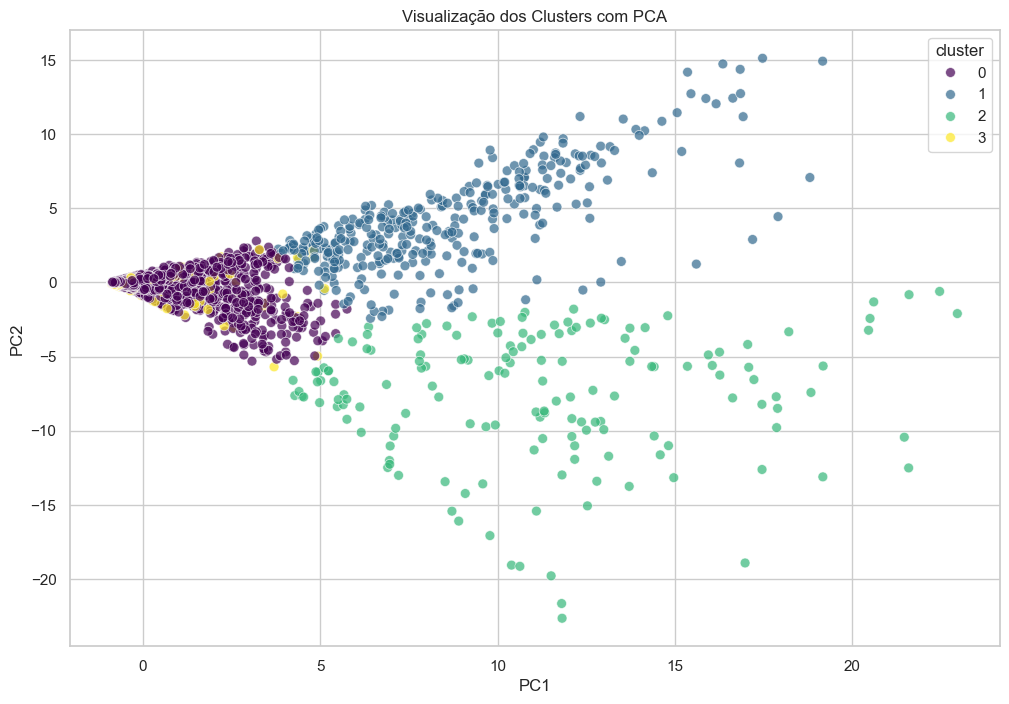

C:\Users\arthu\AppData\Local\Temp\ipykernel_8808\900332901.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_empresas, x='momento_empresa', order=['Início', 'Expansão', 'Maturidade', 'Declínio'], palette='viridis')


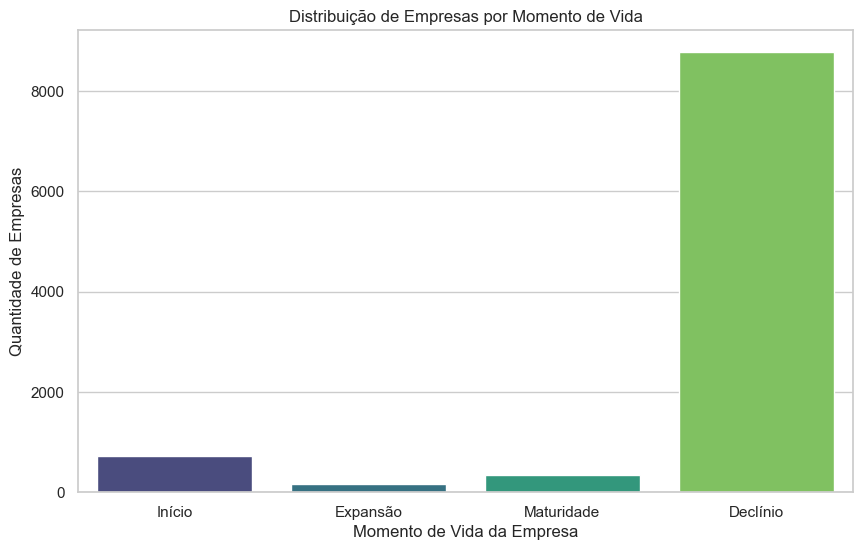

C:\Users\arthu\AppData\Local\Temp\ipykernel_8808\900332901.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_empresas, x='momento_empresa', y=feature, order=['Início', 'Expansão', 'Maturidade', 'Declínio'], palette='viridis')
C:\Users\arthu\AppData\Local\Temp\ipykernel_8808\900332901.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_empresas, x='momento_empresa', y=feature, order=['Início', 'Expansão', 'Maturidade', 'Declínio'], palette='viridis')
C:\Users\arthu\AppData\Local\Temp\ipykernel_8808\900332901.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=Fals

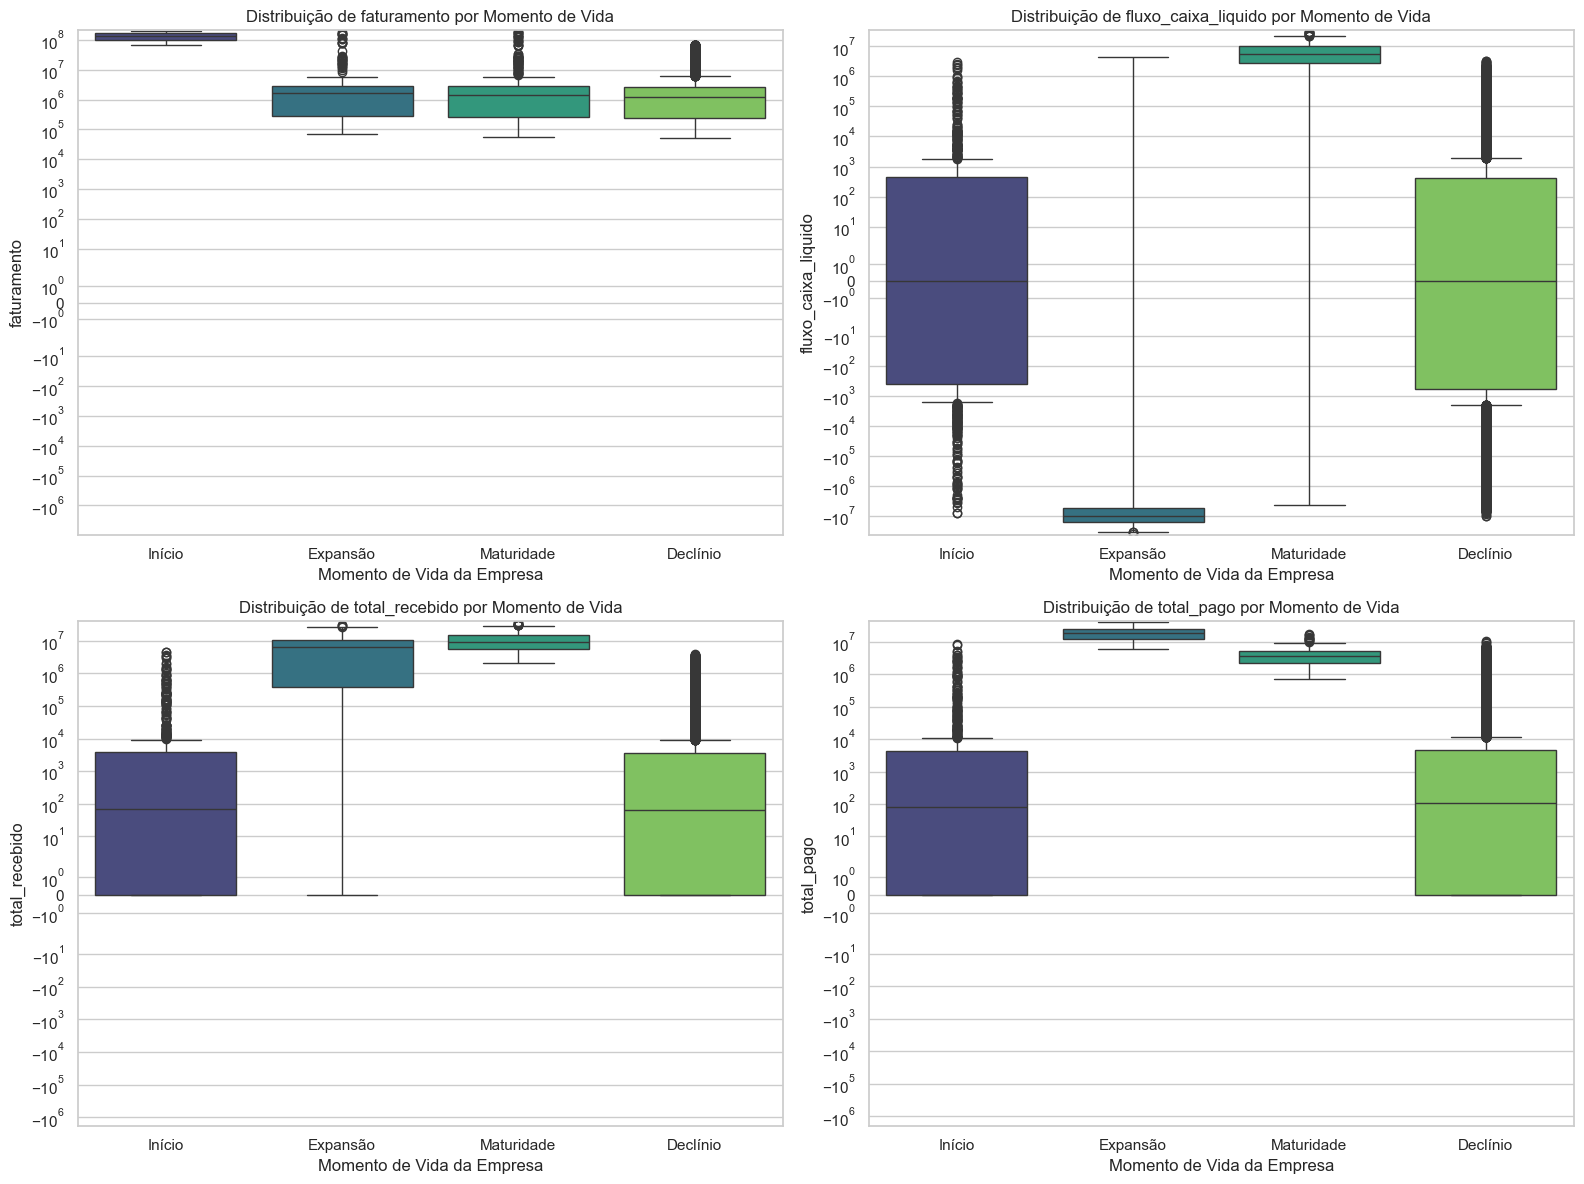

In [4]:
from sklearn.decomposition import PCA

print('--- Perfil Médio de Cada Cluster ---')
perfil_clusters = df_empresas.groupby('cluster')[features_numericas].mean()
print(perfil_clusters)

pca = PCA(n_components=2)
componentes_principais = pca.fit_transform(dados_escalados)
df_pca = pd.DataFrame(data=componentes_principais, columns=['PC1', 'PC2'])
df_pca['cluster'] = df_empresas['cluster'].values

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='cluster', palette='viridis', s=50, alpha=0.7)
plt.title('Visualização dos Clusters com PCA')
plt.show()

# Adicionando o mapeamento de cluster para momento da empresa para os gráficos
mapa_momento = {
    0: 'Declínio',
    1: 'Maturidade',
    2: 'Expansão',
    3: 'Início'
}
df_empresas['momento_empresa'] = df_empresas['cluster'].map(mapa_momento)

# Gráfico de distribuição de empresas por momento
plt.figure(figsize=(10, 6))
sns.countplot(data=df_empresas, x='momento_empresa', order=['Início', 'Expansão', 'Maturidade', 'Declínio'], palette='viridis')
plt.title('Distribuição de Empresas por Momento de Vida')
plt.xlabel('Momento de Vida da Empresa')
plt.ylabel('Quantidade de Empresas')
plt.show()

# Boxplots para features importantes por cluster
features_boxplot = ['faturamento', 'fluxo_caixa_liquido', 'total_recebido', 'total_pago']
plt.figure(figsize=(16, 12))
for i, feature in enumerate(features_boxplot, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df_empresas, x='momento_empresa', y=feature, order=['Início', 'Expansão', 'Maturidade', 'Declínio'], palette='viridis')
    plt.title(f'Distribuição de {feature} por Momento de Vida')
    plt.xlabel('Momento de Vida da Empresa')
    plt.ylabel(feature)
    plt.yscale('symlog') # Usando escala logarítmica para melhor visualização
plt.tight_layout()
plt.show()

## 5. Conclusão

## 6. Comparação de Modelos Supervisionados

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

X = dados_escalados
y = df_empresas['cluster']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
models = {
    'Regressão Logística': LogisticRegression(max_iter=1000, random_state=42),
    'Árvore de Decisão': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy
best_model_name = max(results, key=results.get)
best_model_accuracy = results[best_model_name]

### Conclusão da Análise Supervisionada

## 7. Exportação de Dados para Power BI

In [6]:
mapa_momento = {
    0: 'Declínio',
    1: 'Maturidade',
    2: 'Expansão',
    3: 'Início'
}
df_export = df_empresas.copy()
df_export['momento_empresa'] = df_export['cluster'].map(mapa_momento)
df_export = df_export.reset_index()
output_path = 'data/dados_para_powerbi.csv'
df_export.to_csv(output_path, index=False, sep=';', decimal=',')
print(f'Dados exportados com sucesso para: {output_path}')

Dados exportados com sucesso para: data/dados_para_powerbi.csv


# Desafio 2: Cadeias de Valor e Análise de Redes

Neste desafio, vamos analisar a rede de transações entre as empresas para identificar padrões de relacionamento, empresas centrais (hubs) e comunidades. Usaremos a biblioteca `networkx` para modelar e analisar a rede.

In [7]:
!pip install networkx==3.1
!pip install python-louvain


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## 8. Construção do Grafo de Transações

Vamos modelar as transações como um grafo direcionado, onde cada empresa é um nó e uma aresta representa o fluxo financeiro (pagamento) de uma empresa para outra. O peso das arestas será o valor total transacionado e o número de transações.

In [8]:
import networkx as nx

df_arestas = df_transacoes.groupby(['id_pagador', 'id_recebedor']).agg(
    valor_total=('valor_transacao', 'sum'),
    num_transacoes=('valor_transacao', 'count')
).reset_index()

G = nx.from_pandas_edgelist(
    df_arestas, 
    source='id_pagador', 
    target='id_recebedor', 
    edge_attr=['valor_total', 'num_transacoes'], 
    create_using=nx.DiGraph()
)

print(f'Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.')

Grafo criado com 9000 nós e 45677 arestas.


## 9. Análise de Centralidade e Detecção de Comunidades

Agora, vamos calcular métricas de rede para identificar as empresas mais influentes e detectar comunidades (grupos de empresas com alta interconexão).

In [ ]:
from community import community_louvain

degree_centrality = nx.degree_centrality(G)
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G, k=1000, seed=42)

partition = community_louvain.best_partition(G.to_undirected(), random_state=42)

df_rede = pd.DataFrame(G.nodes(), columns=['id_empresa'])
df_rede['degree_centrality'] = df_rede['id_empresa'].map(degree_centrality)
df_rede['in_degree_centrality'] = df_rede['id_empresa'].map(in_degree_centrality)
df_rede['out_degree_centrality'] = df_rede['id_empresa'].map(out_degree_centrality)
df_rede['betweenness_centrality'] = df_rede['id_empresa'].map(betweenness_centrality)
df_rede['comunidade'] = df_rede['id_empresa'].map(partition)
df_rede.set_index('id_empresa', inplace=True)

df_rede.rename(columns={
    'degree_centrality': 'Centralidade_de_Conexoes',
    'in_degree_centrality': 'Centralidade_de_Recebimentos',
    'out_degree_centrality': 'Centralidade_de_Pagamentos',
    'betweenness_centrality': 'Centralidade_de_Ponte',
    'comunidade': 'Grupo_Empresas'
}, inplace=True)

print('Métricas de rede calculadas com sucesso.')
df_rede.head()

## 10. Análise dos Resultados da Rede

Vamos analisar as empresas com maiores métricas de centralidade e a distribuição das comunidades.

In [ ]:
print('--- Top 10 Empresas por Grau de Centralidade (Hubs) ---')
print(df_rede.sort_values(by='Centralidade_de_Conexoes', ascending=False).head(10))
print('' + '-'*50 + '')

print('--- Top 10 Empresas por Centralidade de Intermediação (Pontes) ---')
print(df_rede.sort_values(by='Centralidade_de_Ponte', ascending=False).head(10))
print('' + '-'*50 + '')

print('--- Distribuição do Tamanho das Comunidades ---')
print(df_rede['Grupo_Empresas'].value_counts().head(15))

--- Top 10 Empresas por Grau de Centralidade (Hubs) ---
            Centralidade_de_Conexoes  Centralidade_de_Recebimentos  \
id_empresa                                                           
CNPJ_00091                  0.027336                      0.014335   
CNPJ_01235                  0.027003                      0.014335   
CNPJ_02281                  0.026225                      0.010001   
CNPJ_01926                  0.026003                      0.010001   
CNPJ_01395                  0.025336                      0.014668   
CNPJ_01381                  0.024558                      0.011779   
CNPJ_00489                  0.024447                      0.012779   
CNPJ_01825                  0.024225                      0.011779   
CNPJ_01118                  0.023558                      0.007445   
CNPJ_01144                  0.022780                      0.008334   

            Centralidade_de_Pagamentos  Centralidade_de_Ponte  Grupo_Empresas  
id_empresa             

## 11. Exportação dos Dados da Análise de Rede

Finalmente, vamos exportar os dados da análise de rede para um arquivo CSV, que pode ser usado para visualizações mais avançadas no Power BI, Gephi ou outra ferramenta.

In [ ]:
df_rede_completo = df_empresas.join(df_rede, how='left')
df_rede_completo['Grupo_Empresas'] = df_rede_completo['Grupo_Empresas'].fillna(-1).astype(int)

df_export_rede = df_rede_completo.reset_index()

output_path_rede = 'data/dados_rede_para_powerbi.csv'

df_export_rede.to_csv(output_path_rede, index=False, sep=';', decimal=',')

print(f'Dados da análise de rede exportados com sucesso para: {output_path_rede}')

Dados da análise de rede exportados com sucesso para: data/dados_rede_para_powerbi.csv
